In [1]:
import numpy as np

## Данные

В этом ноутбуке поработаем с задачей регрессии. В sklearn.dataset есть несколько функций, которые могут генерировать хитрые задачи регрессии.

Отделим 30 процентов данных на валидационную выборку.

In [2]:
from sklearn.datasets import make_friedman3, make_friedman2, make_friedman1

X, y = make_friedman2(n_samples=100, noise=0.2, random_state=3)

n_train = 70
x_train, x_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

Посмотрим распределения входных и выходных переменных.

Text(0.5, 1.0, 'y')

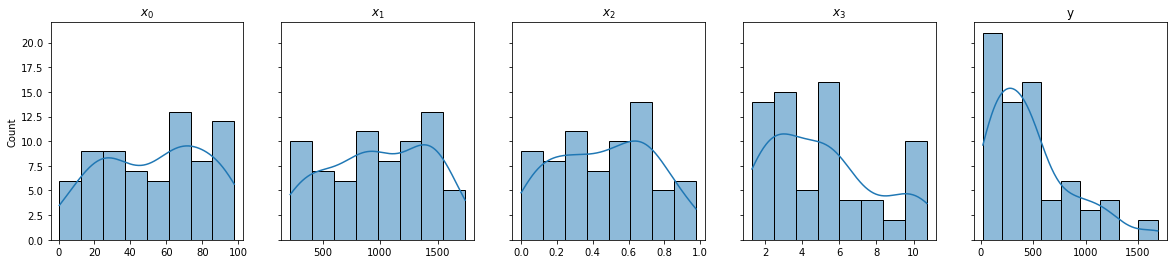

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols = x_train.shape[1] + 1 , figsize=((x_train.shape[1] + 1) * 4, 4), sharey=True)
for i, a in enumerate(ax[:-1]):
    sns.histplot(x_train[:,i], kde=True, ax = a)
    a.set_title(f'$x_{i}$')

sns.histplot(y_train, kde=True, ax = ax[-1])
ax[-1].set_title('y')



Обратите внимание, что диапазоны изменений всех переменных существенно различаются, а распределение выходной переменной сильно смещено в сторону меньших значений.

## Нейронная сеть

Создадим нейронную сеть.

На выходе сети используем линейный нейон, так как это задача регрессии.

Обратите внимание, что используется библиотека keras, которая находится внтури tensorflow. Последняя версия keras может быть найдена именно там, а в этом ноутбуке будут продемонстированы некоторые возможности, которые доступны только в ней.

In [4]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

def make_model():
    model = Sequential()
    model.add(Dense(100, input_dim=4, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    return model

model = make_model()

Обучим сеть.

In [5]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1000, verbose=0)

Посмотрим статистики обучения.

In [6]:
train_err = model.evaluate(x_train, y_train, verbose=0)
test_err = model.evaluate(x_test, y_test, verbose=0)
print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err, test_err))

Ошибка на обучающей выборке: 88383.554, ошибка на тестовой выборке: 72049.430


Посмотрим на график изменения функции ошибки во время обучения.

In [7]:
from matplotlib import pyplot as plt

def plot_history(history=history):
    fig, ax = plt.subplots(figsize=(15, 4), sharex=True)
    ax.plot(history.history['loss'], label='Обучающая выборка')
    ax.plot(history.history['val_loss'], label='Тестовая выборка')
    ax.set_ylabel('MSE')
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.legend()
    ax.grid(True)
    plt.show()

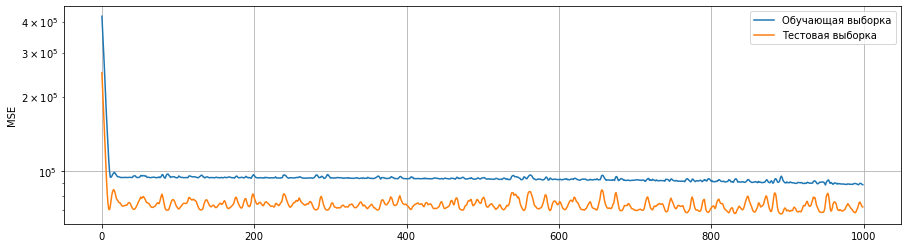

In [8]:
plot_history(history)

Можно видеть, что обучение застопорилось, алгоритм видимо не может спуститься по функции ошибки сложной формы.
Вспомним, что переменные в наших данных имеют очень разные диапазоны, а для обучения нейронных сетей желательно иметь нормализованные данные.

Для нормализации попробуем использовать специальный слой Normalization прямо в составе нашей сети (хотя, видимо, было бы эффективнее нормализовать данные один раз снаружи, чем делать это каждый раз внутри сети, но мы изучаем возможности keras, и вообще это удобно).

In [9]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization

normLayer = Normalization()

Слой нормализации нужно "настроить" на наши данные. Так как это надо делать это один раз, и к тому же лучше на всех данных, а не на отдельных пакетах, то это делается не внутри обучения сети, а с помощью вызова специального метода adapt(), который вызывается перед обучением.

**Важно**: _под всеми данными имеется в виду все данные из **обучающей** подвыборки. Данные из тестовой выборки **не должны никак использоваться в обучении**, в том числе таким, казалось бы, невинным образом. Иначе будет переобучение._ 

In [10]:
normLayer.adapt(x_train)

Теперь можно посмотреть, как этот метод работает. Для этого воспользуемся pandas, чтобы быстро посчитать базовые статистики.
Обратите внимание, что для того, чтобы посмотреть, как слой преобразует данные надо:
* подать данные на вход, как будто слой это функция;
* к выходу применить метод .numpy() чтобы получить данные в виде массива цифр, а не ссылку на тензор в вычислительном графе.

In [11]:
import pandas as pd

pd.DataFrame(normLayer(x_train).numpy()).describe()

,0,1,2,3
count,7.000000e+01,7.000000e+01,7.000000e+01,7.000000e+01
mean,2.895083e-08,4.768372e-08,1.543335e-08,1.144196e-09
std,1.007220e+00,1.007220e+00,1.007220e+00,1.007220e+00
min,-1.841497e+00,-1.748861e+00,-1.719684e+00,-1.348178e+00
25%,-8.873548e-01,-8.653410e-01,-7.891770e-01,-8.598292e-01
50%,8.971535e-02,4.086886e-02,8.492379e-02,1.063695e-02
75%,7.235489e-01,9.156908e-01,8.202482e-01,6.092526e-01
max,1.548643e+00,1.716112e+00,1.866965e+00,2.001349e+00


На выходе данные имеют среднее значение (почти) 0 и дисперсию 1, то, что надо.

Теперь сделам новый вариант сети, в котором на входе используется такой слой. Заодно попробуем обычный градиентный спуск.

In [15]:
import tensorflow.keras as keras

def make_model_2():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer= keras.optimizers.SGD(learning_rate=0.001))
    return model

Обучим модель, и посмотрим, что вышло.

In [16]:
model2 = make_model_2()
history = model2.fit(x_train, y_train,
                     validation_data=(x_test, y_test),
                     epochs=1500,
                     verbose=0)

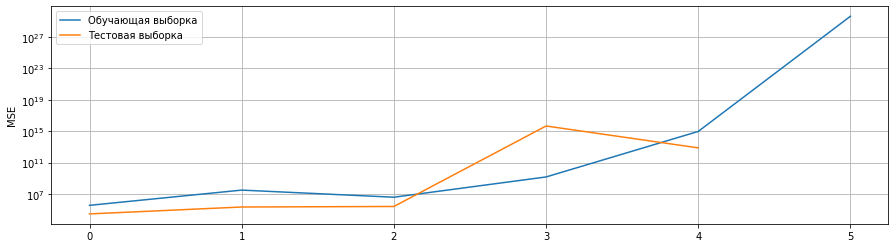

In [17]:
plot_history(history)

Ошибка $10^{27}$ (вообще может быть и $\infty$) и растёт. 

У нас явно в сети начинают циркулировать слишком большие значения. Почему бы не попробовать их ограничить, применив функцию активации с насышением - старый добрый tanh?...

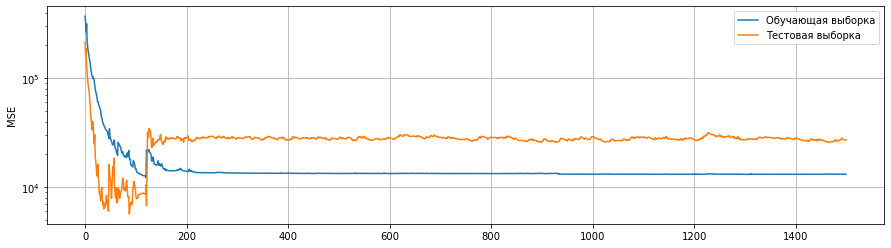

In [19]:
def make_model_2b():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='tanh'))
    model.add(Dense(30, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer= keras.optimizers.SGD(learning_rate=0.001))
    return model

model2b = make_model_2b()
history = model2b.fit(x_train, y_train,
                     validation_data=(x_test, y_test),
                     epochs=1500,
                     verbose=0)

plot_history(history)

Стало лучше, ошибки упали на порядок по сравнению с ненормализованным входом, но всё ещё не очень.
Вспомним, что кроме входа, который мы нормализовали, есть ещё выход, который имеет большой диапазон изменения.

# Задание 1

Попробуйте подобрать для y преборазование, которое стабилизирует обучение. Можно попробовать:
* вычитать среднее;
* делить на дисперсию или на разность между минимумом и максимумом, или между какими-нибудь квантилями;
* просто вычесть что-то на глаз похожее на среднее значение и поделить на что-то похожее на диапазон изменения данных;
* применить, например, логарифм, чтобы попробовать сделать распределение более симметричным.

Какие из этих вариантов сработают?


Преобразование закодируйте в функции normalize. Обратите внимание, что она получает два аргумента:
- y это те данные, которые сейчас нужно нормализовать (обучающий набор во время обучения и тестовый во время валидации);
- y_train всегда должен быть тренировочным набором.

Используйте y_train для того, чтобы рассчитывать какие-нибудь статистики (среднее, дисперсия, etc), которые вы хотите добавлять/умножать для нормализации. Если посчитать статистики прямо по y, то получится разная нормализация для тестовых и проверочных данных, что не правильно (а если проверка будет проводится по одной точке: она или нормализуется в 0 или не изменится вообще). Примерно то же самое происходит со слоем keras.Normalize при вызове adapt() - только он запоминает статистики в переменных класса, а тут, для простоты, предлагается пересчитывать их каждый раз, только из разных наборов.

У меня получилось сделать так, как на картинке. Получится ли у Вас?

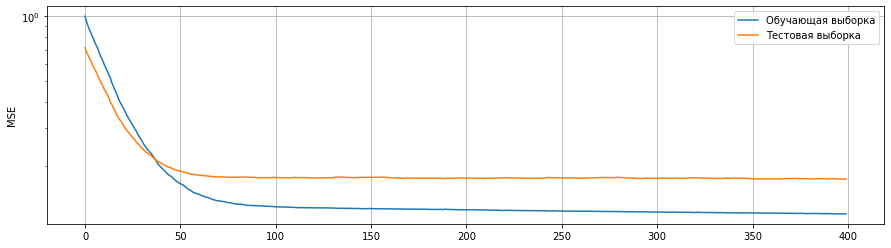

In [20]:
def normalize(y, y_train):
    return какое-то преобразование над y, зависящее от статистик над y_train

model2c = make_model_2b()
history = model2c.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=400,
                     verbose=0)
plot_history(history)

У меня получилось сделать гораздо лучше. И, обратите внимание, ошибки на тестовой и обучающей выборках пришли к разумному состоянию - на обучающей ошибка выше, на тестовой - ниже.

А как, кстати, выглядят данные после перобразования?...

<AxesSubplot:ylabel='Count'>

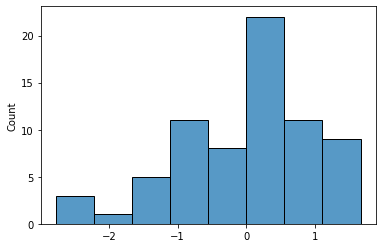

In [21]:
sns.histplot(normalize(y_train, y_train))

Посмотрим на статистики. 

*Обратите внимание, что величина ошибки считается по преобразованному y, поэтому сравнивать ошибки для разных вариантов нормализации таким образом нельзя, особенно если преобразование было нелинейным. Чтобы корректно сравнивать, нужно посчитать выход сети, подвергнуть его обратному преобразованию и сравнить с исходным Y. Для простоты мы тут этого не делаем, и дальше будем везде использовать одно преобразование, так чтобы ошибки были сравнимы. Но с моими числами, оставшимися в этом ноутбуке - не сравнивайте.*

In [22]:
train_err = model2c.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err = model2c.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err, test_err))

Ошибка на обучающей выборке: 0.119, ошибка на тестовой выборке: 0.174


Мы видим, с одной стороны существенную разницу между ошибками на тестовой и обучающей выборками, но, с другой стороны, ошибка на тестовой выбоке пока не растёт. Создаётся впечатление, что результат ещё можно улучшить.

Может быть попробовать вернуться к современным алгоритмам спуска и ReLU... Что нам покажет, например, тот же Adam ?

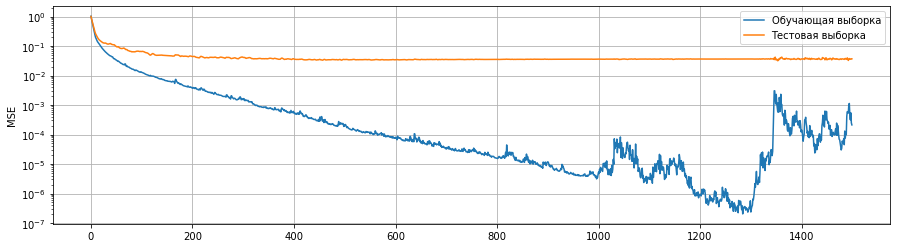

Ошибка на обучающей выборке: 0.000, ошибка на тестовой выборке: 0.037


In [23]:
def make_model_3():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer= keras.optimizers.Adam(learning_rate=0.001))
    return model

model3 = make_model_3()
history = model3.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=1500,
                     verbose=0)
plot_history(history)

train_err = model3.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err = model3.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err, test_err))

Обучение выглядит неустойчивым, но, тем не менее, нам удалось улучшить ошибку на тестовой выборке примерно в 5 раз.

Можем ли мы стабилизировать обучение с помощью уменьшения скорости обучения?

Для этого используем ещё один callback Keras: LearningRateScheduler.
Он уменьшает скорость обучения, по правилам, определяемым переданной ему функцией.

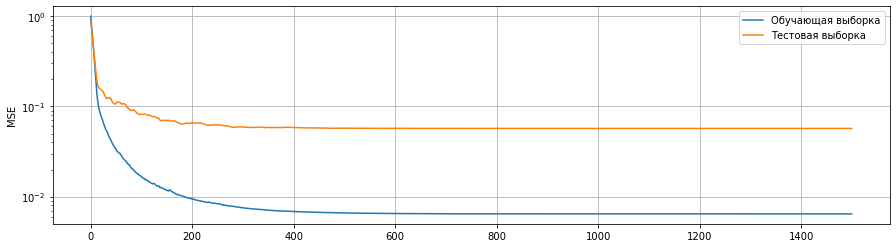

Ошибка на обучающей выборке: 0.006, ошибка на тестовой выборке: 0.057


In [24]:
import tensorflow 

# Эта функция вычисляет новую скорость обучения. Ей задаётся номер эпохи и текущая скорость.
def scheduler(epoch, lr):               
    if epoch < 10:                                    # Первые 10 эпох ничего не меняем
        return lr
    else:
        return lr * tensorflow.math.exp(-0.01)        # Потом умножаем скорость обучения на константу, чуть меньше 1
    
from tensorflow.keras.callbacks import LearningRateScheduler
lr = LearningRateScheduler(scheduler)

def make_model_3b():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer= keras.optimizers.Adam(learning_rate=0.001))
    return model

model3 = make_model_3()
history = model3.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=1500,
                     verbose=0,
                     callbacks=[lr])
plot_history(history)

train_err = model3.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err = model3.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err, test_err))

Затухание скорости обучения стабилизировало процесс, но путём его полной заморозки раньше, чем надо было - мы получили ошибку повыше, чем без него.

Итак, тем не менее, можно спускаться ниже. Давайте попробуем вернутся к "классическому" варианту гиперболического тангенса и SGD. Как мы можем попробовать спуститься c ним ниже? Может быть циклическое изменение скорости обучения?...

Реализация циклического изменения в следующей ячейке взята вот отсюда: https://www.jeremyjordan.me/nn-learning-rate/
Ещё один вариант можно посмотреть, например, тут: https://github.com/bckenstler/CLR

Заодно можно посмотреть, как написать свой Callback для Keras.

In [25]:
from keras.callbacks import Callback
import tensorflow.keras.backend as K
import numpy as np

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

Using TensorFlow backend.


Эта реализация не очень хорошо подходит для определения диапазона допустимых скоростей обучения, так как начинает цикл с максимальной скорости а не с минимальной, поэтому этот шаг пропустим и просто зададим некоторый разумный диапазон.

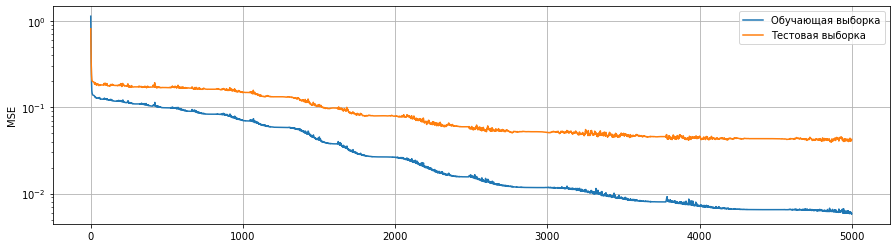

Ошибка на обучающей выборке: 0.008, ошибка на тестовой выборке: 0.046


In [26]:
def make_model_4():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='tanh'))
    model.add(Dense(30, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer= keras.optimizers.SGD(learning_rate=0.001))
    return model

model4 = make_model_4()

schedule = SGDRScheduler(min_lr=1e-5,
                         max_lr=1e-2,
                         steps_per_epoch=1,     # У нас нет пакетов, поэтому в эпохе 1 шаг
                         lr_decay=1,
                         cycle_length=50,
                         mult_factor=1.5)

history = model4.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=5000,
                     verbose=0,
                     callbacks=[schedule])
plot_history(history)

train_err = model4.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err = model4.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err, test_err))

Получилось ниже, чем с фиксированной скоростью обучения, но Adam не догнали... Но, похоже, можно ещё ниже...

Но пока посмотрим такую вещь: SGDRScheduler запоминает во время обучения некоторые статистики, можно на них посмотреть.

Что там есть?

In [27]:
h = schedule.history
print(h.keys())

dict_keys(['lr', 'batch', 'size', 'loss'])


В истории есть:
* lr - скорость обучения;
* batch - номер и размер пакета (у нас всегда одинаково - один пакет на все данные)
* loss - значение ошибки

Посмотрим, например, на график изменения скорости обучения.

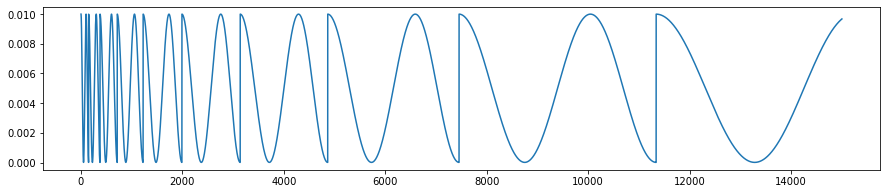

In [29]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(h['lr'])
plt.show()

Видно, что скорость делает итерацию спуск-подъем-спуск по синусоиде, потом резко прыгает до максимума. Периоды изменения скорости растут по мере обучения. Вид этих процессов можно отрегулировать через аргменты конструктора.

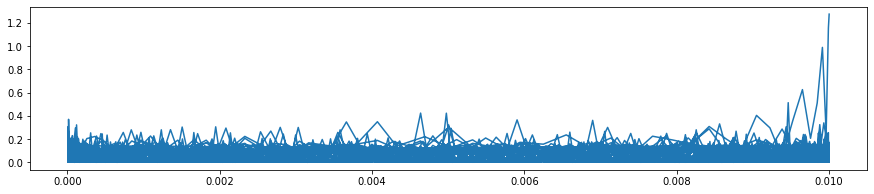

In [31]:
lr = h['lr']
acc = h['loss']

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(lr, acc)

plt.show()

А вот такой график можно было бы использовать для определения диапазона допустимых скоростей обучения, но тут он не очень информативен, единственный пик слева это самое начало обучения, пока сеть училась быстро на первых нескольких прогонах. Дальше влияния скорости обучения особо не видно.

Хотя, если сопоставить график изменения скорости обучения и график самой ошибки обучения, видно, что скорость уменьшения ошибки вполне реагирует на скорость обучения, причём в моменты максимальной скорости обучение не устойчиво, так что увеличивать максимальную скорость тут видимо не стоит.

# Задание 2

Можно ли ещё улучшить результат?

Попробуйте уменьшить ошибку, как для "классического" варианта tanh/SGD так и для "более современного" на основе ReLU. Можно поробовать:
* получится ли стабилизировать ReLU/Adam с помощью более аккуратного уменьшения скорости обучения?
* Градиентный спуск с моментом?
* Метод Нестерова?
* циклическое изменение скорости обучения с Adam?
* другие современные алгоритмы спуска?
* Dropout или Batch Normalization (в Keras есть соответствующие слои)?
* tanh и Adam? ReLU и SGD?
* ...

Получится ли довести сеть до заметного переобучения, когда ошибка на проверочной выборке начнёт расти?

Разумен ли вообще использованный размер сети? Точек данных очень мало, не много ли для них нейронов?

До какого уровня получится довести ошибку на проверочной выборке?

# Задание 3

А не переобучились ли мы, в погоне за уменьшением ошибки на обучающей выборке (а там всего 30 точек)?...

Судя по описанию функции make_friedman2 мы можем получить хорошее представление о "правильном ответе" сгенерировав много точек из неё с noise = 0.

Сгенерируйте данные без шума, и попробуйте с их помощью проверить выбранную в предыдущем задании сеть на переобучение. Каков будет Ваш метод и вывод?

# Задание 4

Работая над этим ноутбуком, я заметил, что эффективность использования обычного или стохастического градиентного спуска (обучение на всех данных без пакетов, или в пакетном режиме) зависит от того, были ли сгенерированы данные с шумом или без него.

Попробуйте провести эксперимент, который бы показал отсутствие или присутствие такого эффекта. Объясните результат.

Я наблюдал разницу при использовании пакетного режима с 70 точек обучающего набора, 30 проверочного и размером пакета 25 примеров (либо без пакетов) и при использовании оптимизатора SGD.